<a href="https://colab.research.google.com/github/swilsonmfc/imbalanced/blob/main/UnderSampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Under-Sampling

# Install

In [ ]:
!pip install imblearn

# Setup

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from sklearn.datasets import make_classification
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.utils.multiclass import unique_labels
from sklearn.svm import LinearSVC
from sklearn.svm import SVC

from imblearn.pipeline import make_pipeline
from imblearn.base import BaseSampler
from imblearn.metrics import classification_report_imbalanced

from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import NearMiss
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.under_sampling import RepeatedEditedNearestNeighbours
from imblearn.under_sampling import AllKNN
from imblearn.under_sampling import TomekLinks

In [ ]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)

# Dataset

In [ ]:
def create_dataset(n_samples=1000, weights=(0.02, 0.98), n_classes=2, class_sep=0.8, n_clusters=1):
    return make_classification(n_samples=n_samples, n_features=2,
                               n_informative=2, n_redundant=0, n_repeated=0,
                               n_classes=n_classes,
                               n_clusters_per_class=n_clusters,
                               weights=list(weights),
                               class_sep=class_sep, 
                               random_state=0)

# Helpers

## Plots

In [ ]:
def plot_resampling(X, y, sampling, ax):
    X_res, y_res = sampling.fit_resample(X, y)
    ax.scatter(X_res[:, 0], X_res[:, 1], c=y_res, alpha=0.8, edgecolor='k')
    # make nice plotting
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    return Counter(y_res)

def plot_decision_function(X, y, clf, ax):
    plot_step = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.4)
    ax.scatter(X[:, 0], X[:, 1], alpha=0.8, c=y, edgecolor='k')
    
def plot_comparison(sampler, X, y):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 7))

    pipe = make_pipeline(LinearSVC())
    pipe.fit(X, y)
    plot_decision_function(X, y, pipe, ax1)
    ax1.set_title('Linear SVC with y={}'.format(Counter(y)))

    plot_resampling(X, y, sampler, ax2)
    ax2.set_title('Resampling using {}'.format(type(sampler).__name__))
    fig.tight_layout()

    pipe = make_pipeline(sampler, LinearSVC())
    pipe.fit(X, y)
    plot_decision_function(X, y, pipe, ax3)
    ax3.set_title('Decision function for {}'.format(type(sampler).__name__))
    
    return pipe

## ROC

In [ ]:
def plot_roc(technique):
  if technique is None:
    pipe = make_pipeline(SVC(probability=True, gamma='auto'))
  else:
    pipe = make_pipeline(technique, SVC(probability=True, gamma='auto'))

  pipe.fit(X, y)
  probs = pipe.predict_proba(X)
  probs = probs[:, 1]

  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
 
  #Imbalanced ROC Curve
  fpr, tpr, thresholds = roc_curve(y, probs)
  auc_roc = roc_auc_score(y, probs)
  ax1.plot([0, 1], [0, 1], linestyle='--')
  ax1.plot(fpr, tpr, marker='.')
  ax1.set_xlabel('False Positive Rate')
  ax1.set_ylabel('True Positive Rate')
  ax1.set_title('ROC Curve - AUC: %.3f' % auc_roc)

  #Precision Recall Curve
  precision, recall, thresholds = precision_recall_curve(y, probs)
  auc_pre_rec = auc(recall, precision)
  no_skill = sum(y) / len(y)
  ax2.plot([0, 1], [no_skill, no_skill], linestyle='--')
  ax2.plot(recall, precision, marker='.')
  ax2.set_xlabel('Recall')
  ax2.set_ylabel('Precision')
  ax2.set_title('Precision Recall Curve - AUC: %.3f' % auc_pre_rec)

  return auc_roc, auc_pre_rec

## Confusion

In [ ]:
def confusion(technique, yHat, y):
    cm = confusion_matrix(y, yHat)
    class_report = classification_report_imbalanced(y, yHat)
    maj_precision = cm[0][0] / (cm[0][0] + cm[1][0])
    maj_recall    = cm[0][0] / (cm[0][0] + cm[0][1])
    min_precision = cm[1][1] / (cm[1][1] + cm[0][1])
    min_recall    = cm[1][1] / (cm[1][1] + cm[1][0])

    plt.figure(figsize=(15,7))
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', cmap='Purples', ax=ax)
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(['Majority', 'Minority'])
    ax.yaxis.set_ticklabels(['Majority', 'Minority'])

    print(class_report)
    return cm, class_report, (maj_precision, maj_recall), (min_precision, min_recall)

# Tracking

In [ ]:
# Keep a summary of how well different techniques work
cols = pd.MultiIndex.from_tuples(zip(['Majority', 'Majority', 'Minority', 'Minority', 'AUC', 'AUC'],
                                     ['Precision', 'Recall', 'Precision', 'Recall', 'ROC', 'Precision/Recall']))

results_df = pd.DataFrame(columns=cols)

In [ ]:
results_df

Empty DataFrame
Columns: [(Majority, Precision), (Majority, Recall), (Minority, Precision), (Minority, Recall), (AUC, ROC), (AUC, Precision/Recall)]
Index: []

# Baseline

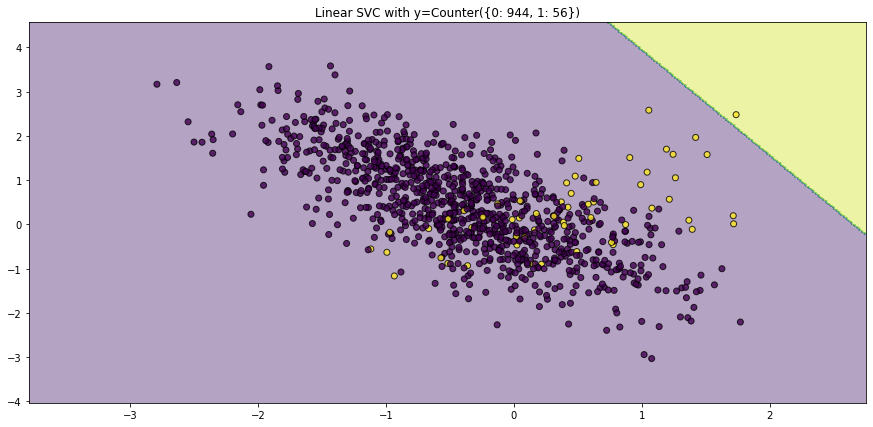

In [ ]:
fig, (ax1) = plt.subplots(1, 1, figsize=(15, 7))
X, y = create_dataset(n_samples=1000, weights=(0.95, 0.05), class_sep=0.4)
pipe = make_pipeline(LinearSVC())
pipe.fit(X, y)
plot_decision_function(X, y, pipe, ax1)
ax1.set_title('Linear SVC with y={}'.format(Counter(y)));

                   pre       rec       spe        f1       geo       iba       sup

          0       0.94      1.00      0.02      0.97      0.13      0.02       944
          1       1.00      0.02      1.00      0.04      0.13      0.02        56

avg / total       0.95      0.94      0.07      0.92      0.13      0.02      1000



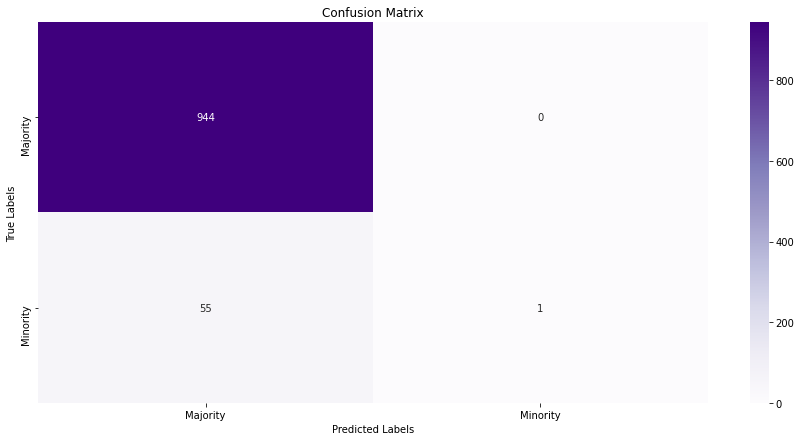

In [ ]:
con, cr, majority, minority = confusion('Baseline', pipe.predict(X), y)

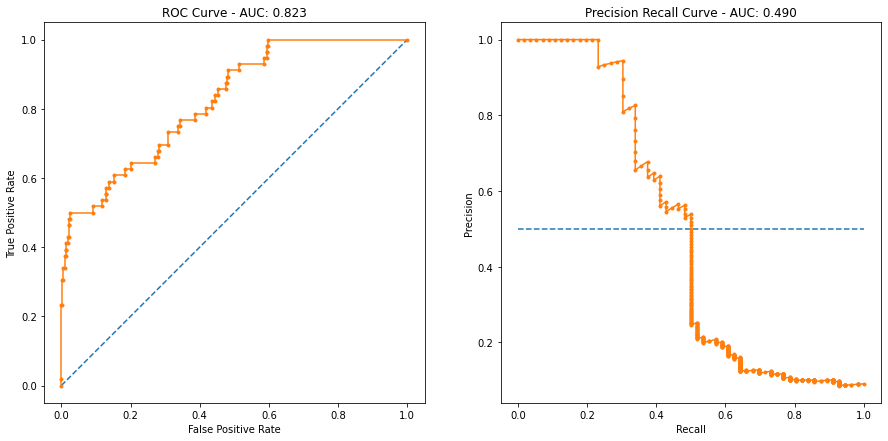

In [ ]:
auc_rec, auc_pre_rec = plot_roc(None)

In [ ]:
results_df.loc['Baseline'] = [*majority, *minority, auc_rec, auc_pre_rec]
results_df

Majority         Minority                 AUC                 
         Precision Recall Precision    Recall       ROC Precision/Recall
Baseline  0.944945    1.0       1.0  0.017857  0.823282         0.490022

# Under Sampling
Achieve balance by increasing the number of minority classes which reduces the imbalance ratio.

## Random Sampling

                   pre       rec       spe        f1       geo       iba       sup

          0       0.98      0.71      0.75      0.82      0.73      0.53       944
          1       0.13      0.75      0.71      0.22      0.73      0.53        56

avg / total       0.93      0.71      0.75      0.79      0.73      0.53      1000



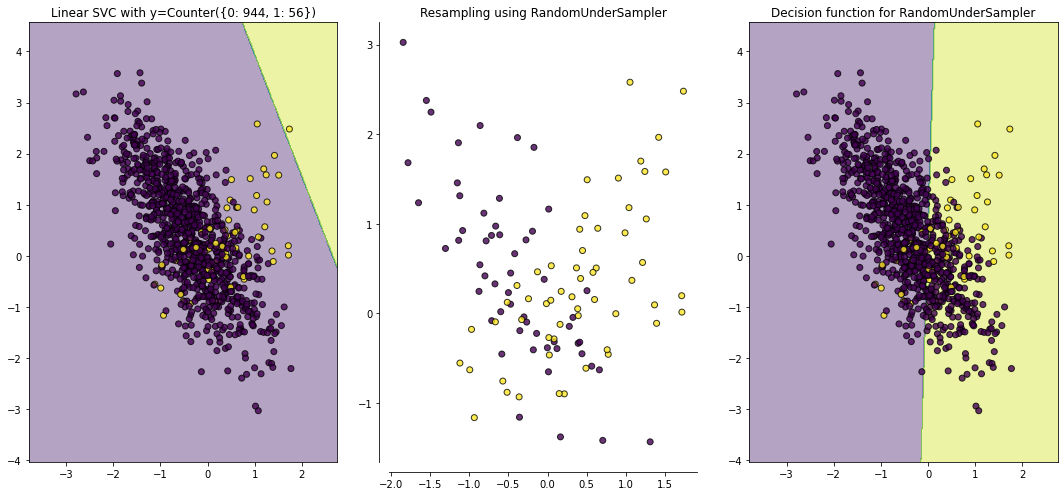

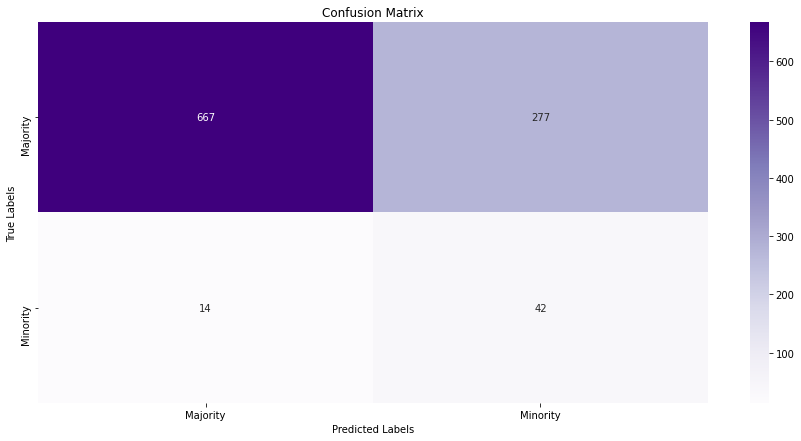

In [ ]:
sampler = RandomUnderSampler(random_state=0)
pipe = plot_comparison(sampler, X, y)
con, cr, majority, minority = confusion('Random Under Sampling', pipe.predict(X), y)

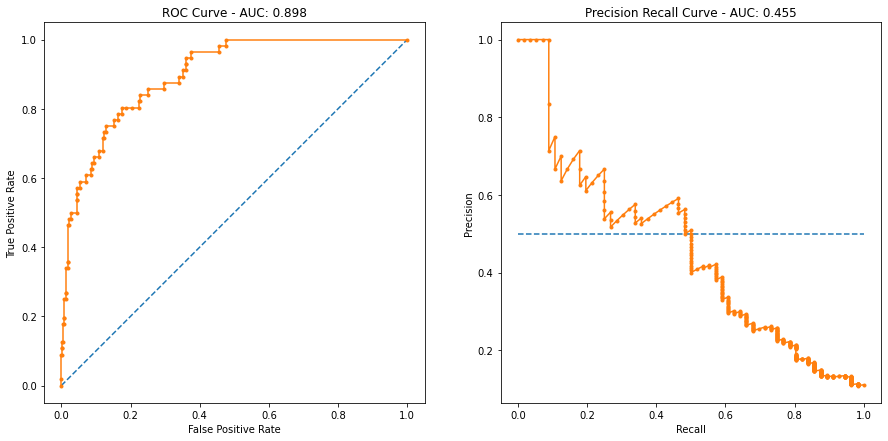

In [ ]:
auc_rec, auc_pre_rec = plot_roc(sampler)

In [ ]:
results_df.loc['Random Under Sampling'] = [*majority, *minority, auc_rec, auc_pre_rec]
results_df

Majority            ...       AUC                 
                      Precision    Recall  ...       ROC Precision/Recall
Baseline               0.944945  1.000000  ...  0.823282         0.490022
Random Under Sampling  0.979442  0.706568  ...  0.898438         0.454622

[2 rows x 6 columns]

## TomekLinks
* Find pairs where the distance to the nearest neighbor of a different class
* Remove the majority classification

![](https://mlwhiz.com/images/imbal/1.png)





                   pre       rec       spe        f1       geo       iba       sup

          0       0.94      1.00      0.02      0.97      0.13      0.02       944
          1       1.00      0.02      1.00      0.04      0.13      0.02        56

avg / total       0.95      0.94      0.07      0.92      0.13      0.02      1000



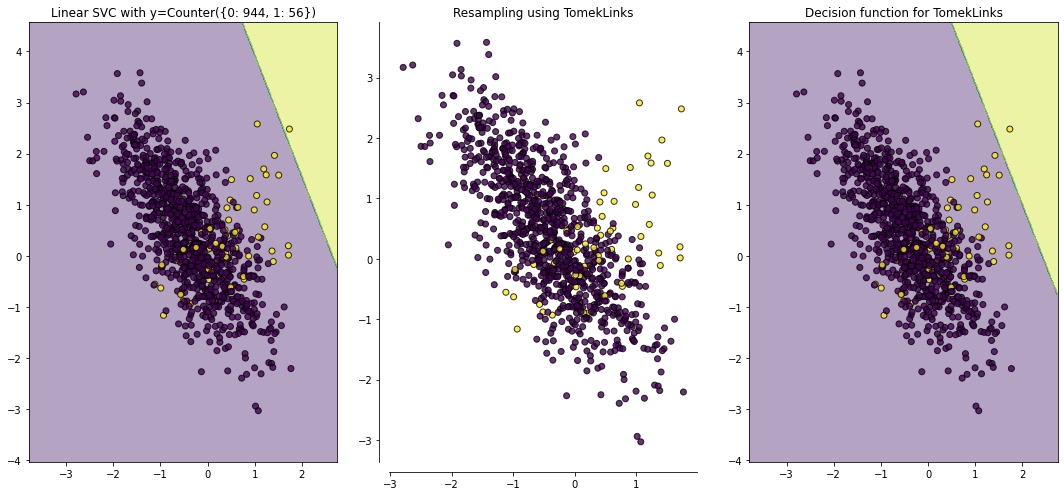

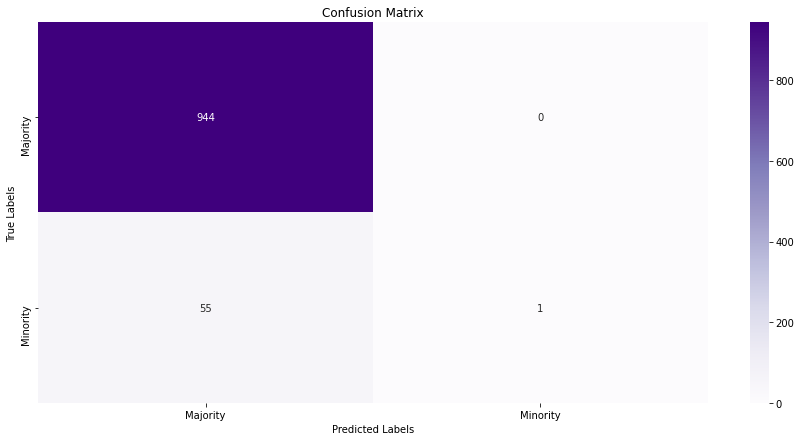

In [ ]:
sampler = TomekLinks()
pipe = plot_comparison(sampler, X, y)
con, cr, majority, minority = confusion('TomekLinks', pipe.predict(X), y)

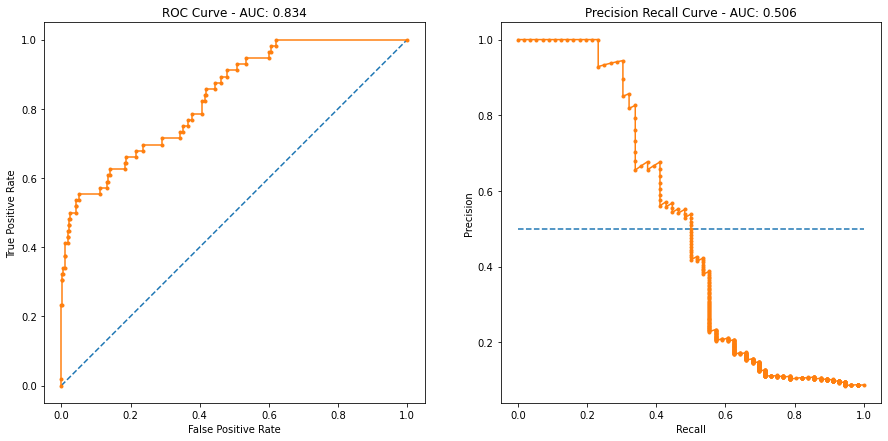

In [ ]:
auc_rec, auc_pre_rec = plot_roc(sampler)

In [ ]:
results_df.loc['TomekLinks'] = [*majority, *minority, auc_rec, auc_pre_rec]
results_df

Majority            ...       AUC                 
                      Precision    Recall  ...       ROC Precision/Recall
Baseline               0.944945  1.000000  ...  0.823282         0.490022
Random Under Sampling  0.979442  0.706568  ...  0.898438         0.454622
TomekLinks             0.944945  1.000000  ...  0.834292         0.505559

[3 rows x 6 columns]

## NearMiss
Near Miss algorithms implement some heuristic rules in order to select samples. 
* NearMiss-1 Samples from the majority class where the average distance of the k nearest samples of the minority class is the smallest. 
* NearMiss-2 Samples from the majority class where the average distance to the farthest samples of the minority class is the smallest. 
* NearMiss-3 2-step algorithm: 
 * For each minority sample, find M nearest-neighbors will be kept  
 * The majority samples kept are those where the average distance to the k nearest neighbors is the largest

 ![](https://glemaitre.github.io/imbalanced-learn/_images/sphx_glr_plot_nearmiss_001.png)




### NearMiss-1





                   pre       rec       spe        f1       geo       iba       sup

          0       0.97      0.82      0.57      0.89      0.68      0.48       944
          1       0.16      0.57      0.82      0.24      0.68      0.45        56

avg / total       0.92      0.80      0.59      0.85      0.68      0.48      1000



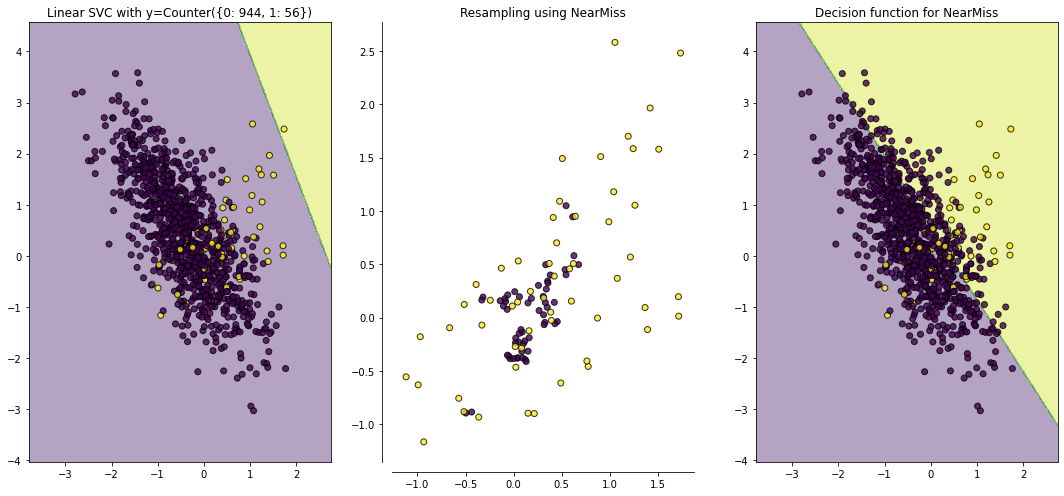

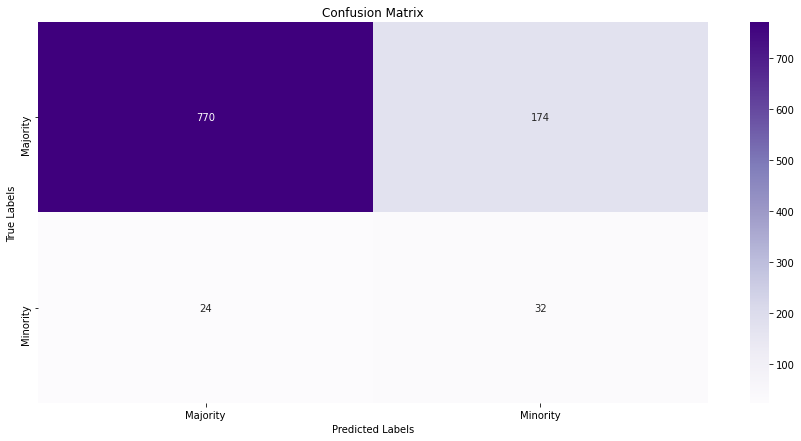

In [ ]:
sampler = NearMiss(version=1)
pipe = plot_comparison(sampler, X, y)
con, cr, majority, minority = confusion('NearMiss-1', pipe.predict(X), y)

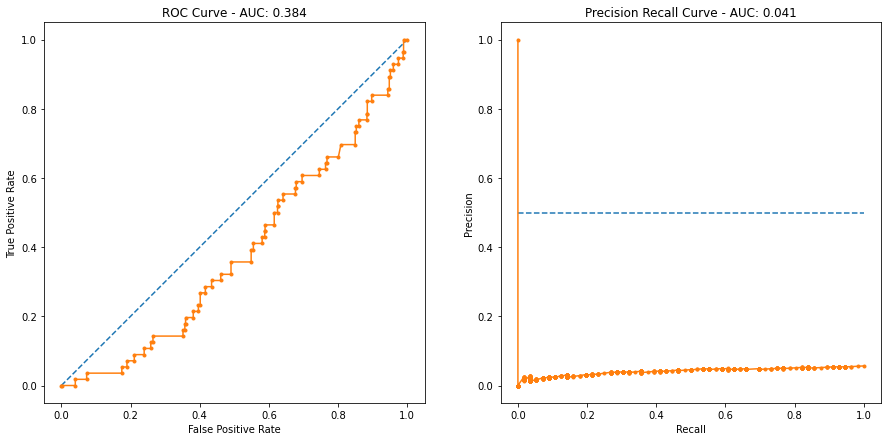

In [ ]:
auc_rec, auc_pre_rec = plot_roc(sampler)

In [ ]:
results_df.loc['NearMiss-1'] = [*majority, *minority, auc_rec, auc_pre_rec]
results_df

Majority            ...       AUC                 
                      Precision    Recall  ...       ROC Precision/Recall
Baseline               0.944945  1.000000  ...  0.823282         0.490022
Random Under Sampling  0.979442  0.706568  ...  0.898438         0.454622
TomekLinks             0.944945  1.000000  ...  0.834292         0.505559
NearMiss-1             0.969773  0.815678  ...  0.383607         0.041358

[4 rows x 6 columns]

### NearMiss-2





                   pre       rec       spe        f1       geo       iba       sup

          0       0.97      0.63      0.68      0.76      0.65      0.42       944
          1       0.10      0.68      0.63      0.17      0.65      0.43        56

avg / total       0.92      0.63      0.68      0.73      0.65      0.42      1000



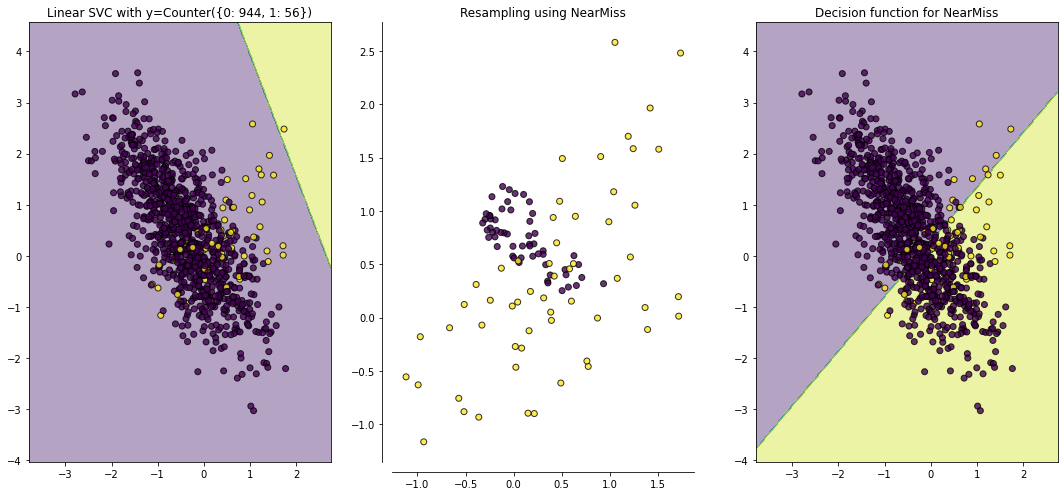

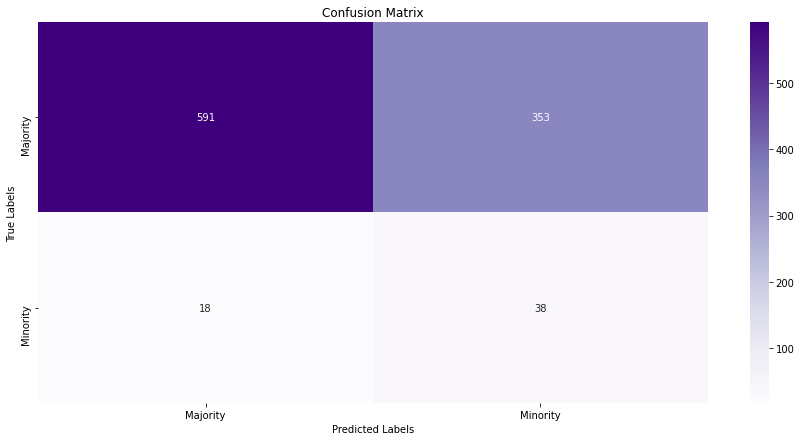

In [ ]:
sampler = NearMiss(version=2)
pipe = plot_comparison(sampler, X, y)
con, cr, majority, minority = confusion('NearMiss-2', pipe.predict(X), y)

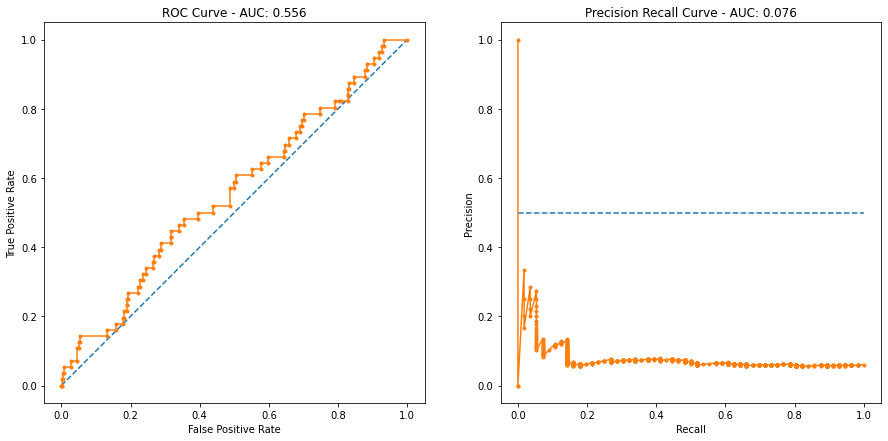

In [ ]:
auc_rec, auc_pre_rec = plot_roc(sampler)

In [ ]:
results_df.loc['NearMiss-2'] = [*majority, *minority, auc_rec, auc_pre_rec]
results_df

Majority            ...       AUC                 
                      Precision    Recall  ...       ROC Precision/Recall
Baseline               0.944945  1.000000  ...  0.823282         0.490022
Random Under Sampling  0.979442  0.706568  ...  0.898438         0.454622
TomekLinks             0.944945  1.000000  ...  0.834292         0.505559
NearMiss-1             0.969773  0.815678  ...  0.383607         0.041358
NearMiss-2             0.970443  0.626059  ...  0.555671         0.076450

[5 rows x 6 columns]

### NearMiss-3

                   pre       rec       spe        f1       geo       iba       sup

          0       0.97      0.81      0.59      0.88      0.69      0.49       944
          1       0.16      0.59      0.81      0.25      0.69      0.47        56

avg / total       0.93      0.80      0.60      0.85      0.69      0.49      1000



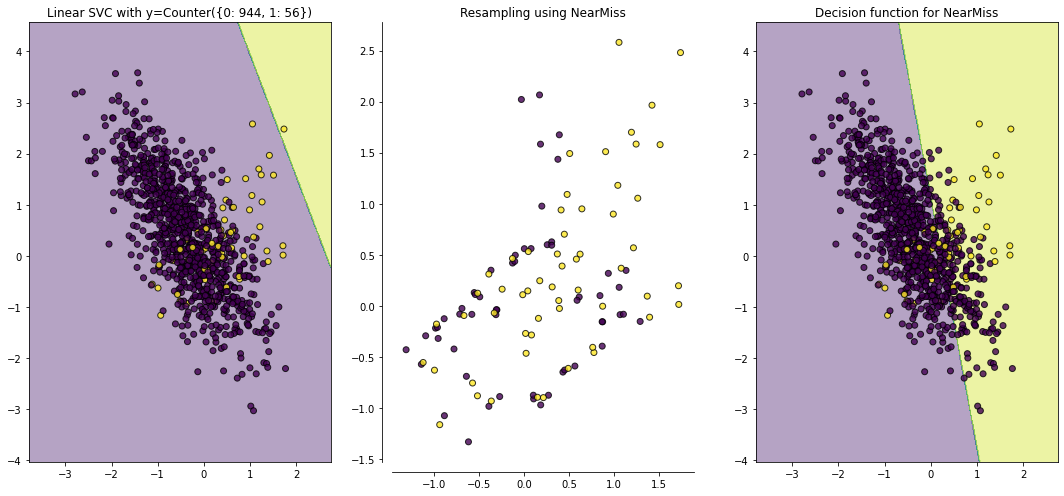

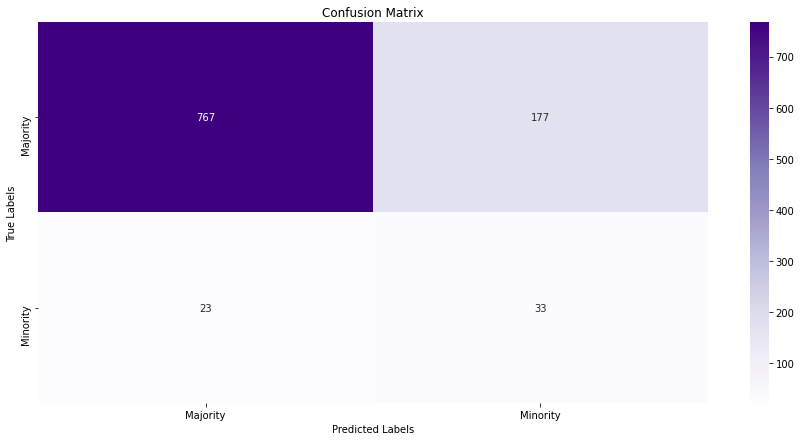

In [ ]:
sampler = NearMiss(version=3)
pipe = plot_comparison(sampler, X, y)
con, cr, majority, minority = confusion('NearMiss-3', pipe.predict(X), y)

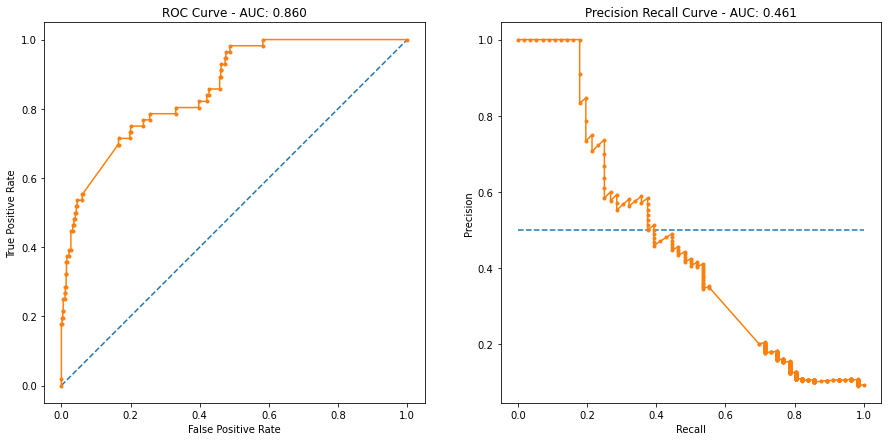

In [ ]:
auc_rec, auc_pre_rec = plot_roc(sampler)

In [ ]:
results_df.loc['NearMiss-3'] = [*majority, *minority, auc_rec, auc_pre_rec]
results_df

Majority            ...       AUC                 
                      Precision    Recall  ...       ROC Precision/Recall
Baseline               0.944945  1.000000  ...  0.823282         0.490022
Random Under Sampling  0.979442  0.706568  ...  0.898438         0.454622
TomekLinks             0.944945  1.000000  ...  0.834292         0.505559
NearMiss-1             0.969773  0.815678  ...  0.383607         0.041358
NearMiss-2             0.970443  0.626059  ...  0.555671         0.076450
NearMiss-3             0.970886  0.812500  ...  0.859526         0.460759

[6 rows x 6 columns]

## EditedNearestNeighbours

![](https://lh3.googleusercontent.com/proxy/ih7ib58FWvEZoc-0fLqQiwiCHtn7cQRqKkapZXSfN-_8rZCBKkmkIPlPIYmKoue-zvNDcfhBgYOV3rMerpNJvxWSrgzRsXeUuXqg4ePVJIna4MCHABaOkt23IIW5PxlYnUi16mQV8DPlSR0)








                   pre       rec       spe        f1       geo       iba       sup

          0       0.95      1.00      0.04      0.97      0.19      0.04       944
          1       1.00      0.04      1.00      0.07      0.19      0.03        56

avg / total       0.95      0.95      0.09      0.92      0.19      0.04      1000



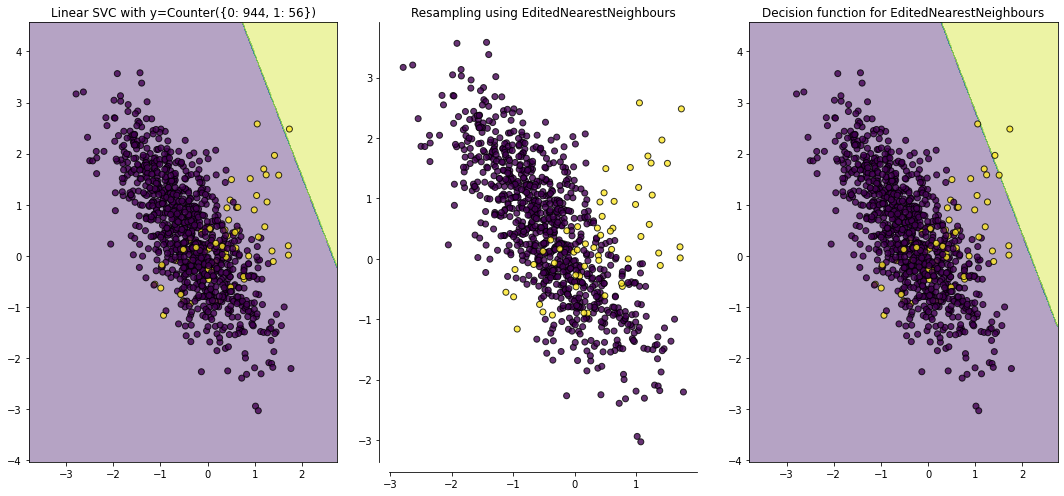

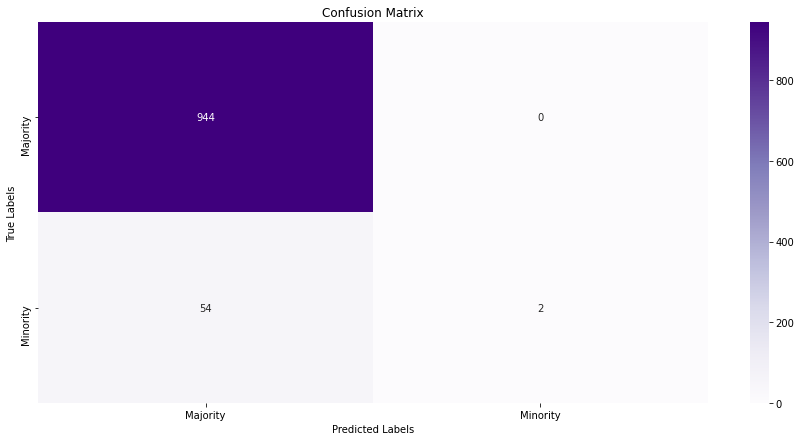

In [ ]:
sampler = EditedNearestNeighbours()
pipe = plot_comparison(sampler, X, y)
con, cr, majority, minority = confusion('EditedNearestNeighbors', pipe.predict(X), y)

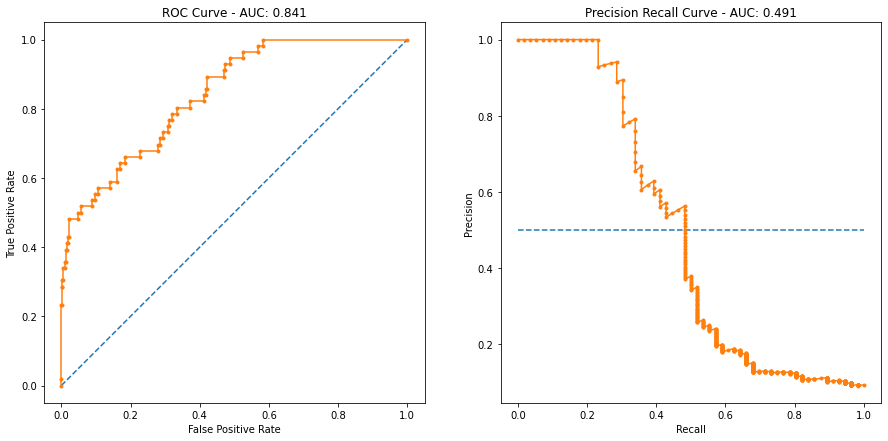

In [ ]:
auc_rec, auc_pre_rec = plot_roc(sampler)

In [ ]:
results_df.loc['EditedNearestNeighbors'] = [*majority, *minority, auc_rec, auc_pre_rec]
results_df

Majority            ...       AUC                 
                       Precision    Recall  ...       ROC Precision/Recall
Baseline                0.944945  1.000000  ...  0.823282         0.490022
Random Under Sampling   0.979442  0.706568  ...  0.898438         0.454622
TomekLinks              0.944945  1.000000  ...  0.834292         0.505559
NearMiss-1              0.969773  0.815678  ...  0.383607         0.041358
NearMiss-2              0.970443  0.626059  ...  0.555671         0.076450
NearMiss-3              0.970886  0.812500  ...  0.859526         0.460759
EditedNearestNeighbors  0.945892  1.000000  ...  0.841367         0.491467

[7 rows x 6 columns]

## Repeated Edited Nearest Neighbors

                   pre       rec       spe        f1       geo       iba       sup

          0       0.95      1.00      0.07      0.97      0.27      0.08       944
          1       1.00      0.07      1.00      0.13      0.27      0.06        56

avg / total       0.95      0.95      0.12      0.93      0.27      0.08      1000



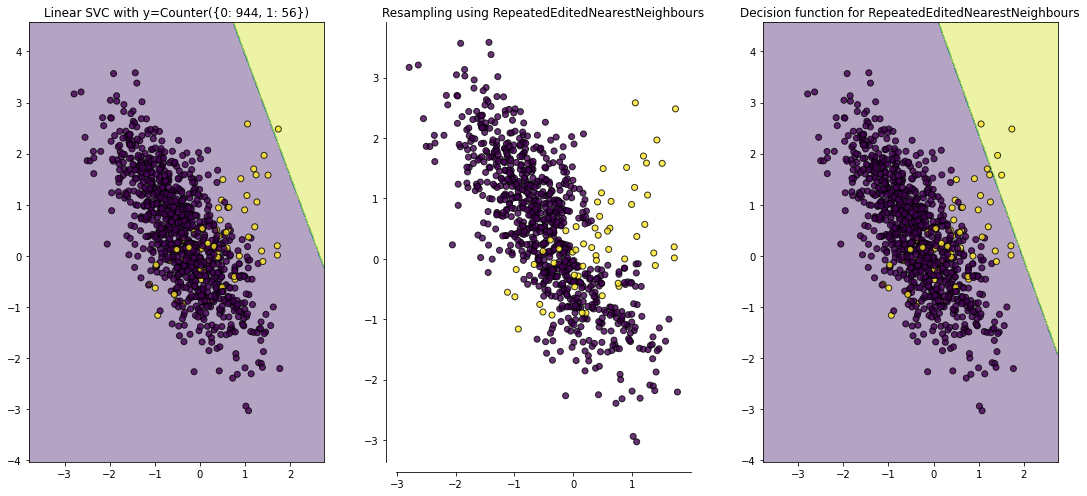

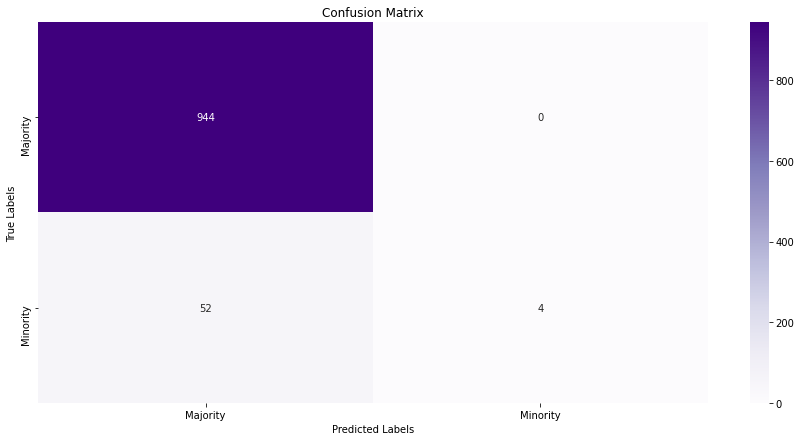

In [ ]:
sampler = RepeatedEditedNearestNeighbours()
pipe = plot_comparison(sampler, X, y)
con, cr, majority, minority = confusion('RepeatedEditedNearestNeighbors', pipe.predict(X), y)

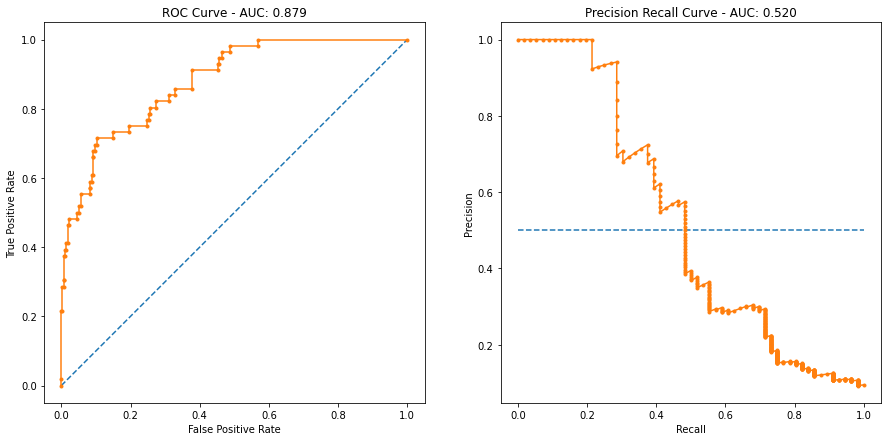

In [ ]:
auc_rec, auc_pre_rec = plot_roc(sampler)

In [ ]:
results_df.loc['RepeatedEditedNearestNeighbors'] = [*majority, *minority, auc_rec, auc_pre_rec]
results_df

Majority            ...       AUC                 
                               Precision    Recall  ...       ROC Precision/Recall
Baseline                        0.944945  1.000000  ...  0.823282         0.490022
Random Under Sampling           0.979442  0.706568  ...  0.898438         0.454622
TomekLinks                      0.944945  1.000000  ...  0.834292         0.505559
NearMiss-1                      0.969773  0.815678  ...  0.383607         0.041358
NearMiss-2                      0.970443  0.626059  ...  0.555671         0.076450
NearMiss-3                      0.970886  0.812500  ...  0.859526         0.460759
EditedNearestNeighbors          0.945892  1.000000  ...  0.841367         0.491467
RepeatedEditedNearestNeighbors  0.947791  1.000000  ...  0.879313         0.519569

[8 rows x 6 columns]

## AllKNN



                   pre       rec       spe        f1       geo       iba       sup

          0       0.95      1.00      0.07      0.97      0.27      0.08       944
          1       1.00      0.07      1.00      0.13      0.27      0.06        56

avg / total       0.95      0.95      0.12      0.93      0.27      0.08      1000



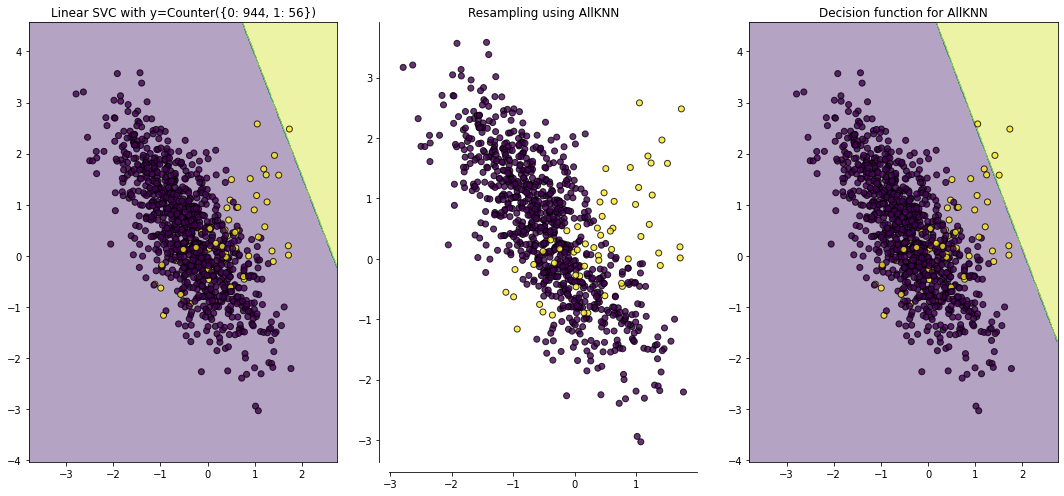

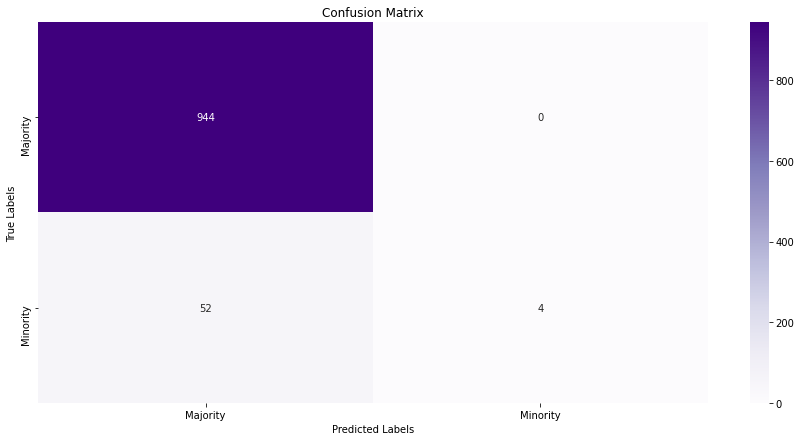

In [ ]:
sampler = AllKNN(allow_minority=True)
pipe = plot_comparison(sampler, X, y)
con, cr, majority, minority = confusion('AllKNN', pipe.predict(X), y)

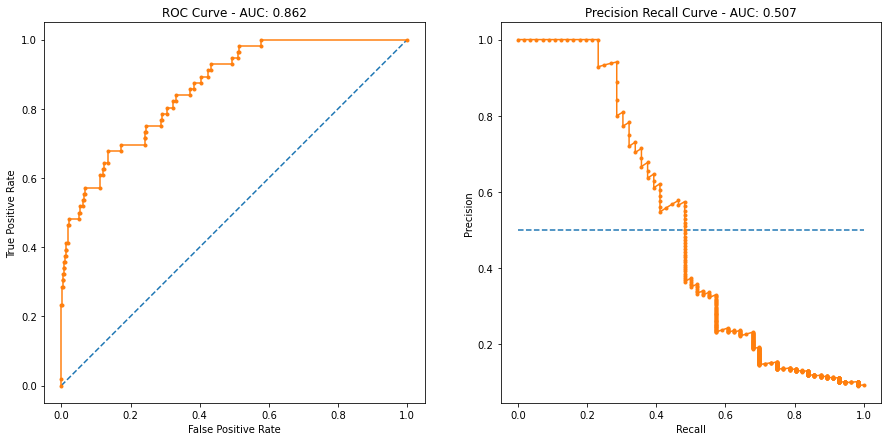

In [ ]:
auc_rec, auc_pre_rec = plot_roc(sampler)

In [ ]:
results_df.loc['AllKNN'] = [*majority, *minority, auc_rec, auc_pre_rec]
results_df

Majority            ...       AUC                 
                               Precision    Recall  ...       ROC Precision/Recall
Baseline                        0.944945  1.000000  ...  0.823282         0.490022
Random Under Sampling           0.979442  0.706568  ...  0.898438         0.454622
TomekLinks                      0.944945  1.000000  ...  0.834292         0.505559
NearMiss-1                      0.969773  0.815678  ...  0.383607         0.041358
NearMiss-2                      0.970443  0.626059  ...  0.555671         0.076450
NearMiss-3                      0.970886  0.812500  ...  0.859526         0.460759
EditedNearestNeighbors          0.945892  1.000000  ...  0.841367         0.491467
RepeatedEditedNearestNeighbors  0.947791  1.000000  ...  0.879313         0.519569
AllKNN                          0.947791  1.000000  ...  0.861985         0.507254

[9 rows x 6 columns]

# Results

## Top Majority Precision

In [ ]:
results_df.sort_values(('Majority', 'Precision'), ascending=False).head(3)

Majority            ...       AUC                 
                      Precision    Recall  ...       ROC Precision/Recall
Random Under Sampling  0.979442  0.706568  ...  0.898438         0.454622
NearMiss-3             0.970886  0.812500  ...  0.859526         0.460759
NearMiss-2             0.970443  0.626059  ...  0.555671         0.076450

[3 rows x 6 columns]

## Top Minority Recall

In [ ]:
results_df.sort_values(('Minority', 'Recall'), ascending=False).head(3)

Majority            ...       AUC                 
                      Precision    Recall  ...       ROC Precision/Recall
Random Under Sampling  0.979442  0.706568  ...  0.898438         0.454622
NearMiss-2             0.970443  0.626059  ...  0.555671         0.076450
NearMiss-3             0.970886  0.812500  ...  0.859526         0.460759

[3 rows x 6 columns]

## Top AUC

In [ ]:
results_df.sort_values(('AUC', 'ROC'), ascending=False).head(3)

Majority            ...       AUC                 
                               Precision    Recall  ...       ROC Precision/Recall
Random Under Sampling           0.979442  0.706568  ...  0.898438         0.454622
RepeatedEditedNearestNeighbors  0.947791  1.000000  ...  0.879313         0.519569
AllKNN                          0.947791  1.000000  ...  0.861985         0.507254

[3 rows x 6 columns]

# Practical
* Might be useful when you have large numbers of majority class
* Consider trying over-sampling if you have smaller data